In [1]:
# IMPORT ALL THE LIBRARIES USED IN THE NOTEBOOK
import math
import plotly.subplots as psu
import matplotlib.pyplot as plt

from waffles.data_classes.WaveformSet import WaveformSet


In [2]:
runnumber = 29177
from waffles.input.pickle_file_to_WaveformSet import pickle_file_to_WaveformSet

file = f'/eos/home-h/hvieirad/waffles/analysis/rawdata/waffles_tau_slow_protoDUNE_HD/wfset_run0{runnumber}.pkl'

wfset = pickle_file_to_WaveformSet(file)


In [8]:
from extract_selection import Extractor

extractor = Extractor("template")

In [22]:
extractor.loadcuts("template")
wfset_ch = WaveformSet.from_filtered_WaveformSet( wfset, extractor.allow_certain_endpoints_channels, [112] , [11227])
len(wfset_ch.waveforms)


41632

(50.0, 200.0)

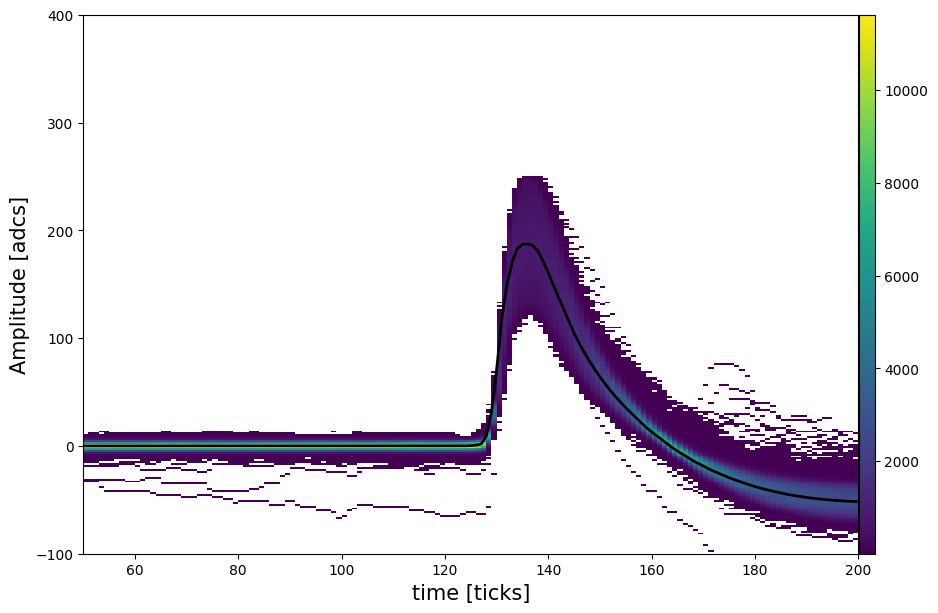

In [62]:
import pickle
import numpy as np
from waffles.utils.denoising.tv1ddenoise import Denoise

times = np.linspace(0, 1024, 1024, endpoint=False)
time_arrays = np.tile(times, (len(wfset_ch.waveforms), 1))
wvf_arrays = np.array([(waveform.filtered - waveform.baseline)*-1 for waveform in wfset_ch.waveforms])


h, yedges, xedges = np.histogram2d(wvf_arrays.flatten(), time_arrays.flatten(), bins=(280,1024), range = [[-100,400],[0,1024]])
h[h==0] = np.nan
fig, ax = plt.subplots(1, 1, figsize=(10,7))

x, y = np.meshgrid(xedges, yedges)
pcm = ax.pcolormesh(x, y, h)
ax.set_ylabel("Amplitude [adcs]", fontsize=15)
ax.set_xlabel("time [ticks]", fontsize=15)
cax = ax.inset_axes([1.001, 0., 0.02, 1.])
plt.colorbar(pcm, ax=ax, cax=cax)

avgwvf = np.mean(wvf_arrays, axis=0)
res0, status = extractor.compute_baseline(avgwvf)
avgwvf-=res0
plt.plot(avgwvf, '-k', lw=2)
wfset_ch.avgwvf = avgwvf
plt.xlim(50,200)
# pickleavgname = f'templates/template_run0{runnumber}.pkl'
# with open(pickleavgname, "wb") as f:
#     pickle.dump(wfset_ch, f)


(0.0, 200.0)

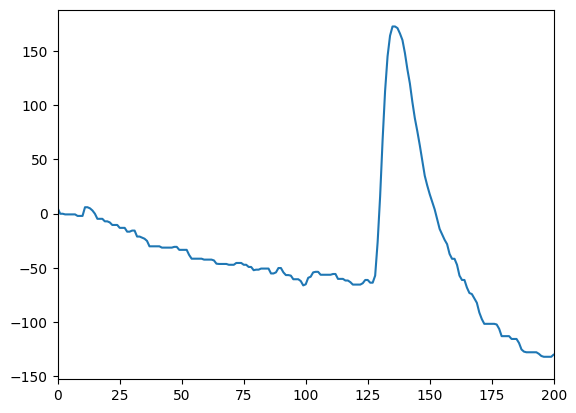

In [64]:
# wvftest = wfset_ch.waveforms[0]

# plt.plot((wvftest.adcs-wvftest.baseline)*-1)
# plt.plot((wvftest.filtered-wvftest.baseline)*-1)
wvfs = np.array([ (wvf.filtered-wvf.baseline)*-1 for wvf in wfset_ch.waveforms])
pi = np.argmin(np.min(wvfs[:,100:120],axis=1))
plt.plot(wvfs[pi])
plt.xlim(0,200)
